In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import json

if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Is occupancy a good predictor of energy consumed?
#### If we have data on the energy consumed by a building how well does that relate to the number of units in the building?

In [2]:
os.getenv('PUIDATA')
#RETURNS STRING ASSOC WITH THAT ENVIRONMENT. CONFIRMING PUIdata exists.

'/home/cusp/mal824/PUIdata'

In [3]:
!curl -O "https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv" #code to download csv files from url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3110k    0 3110k    0     0  9298k      0 --:--:-- --:--:-- --:--:-- 22.0M


In [4]:
os.system("mv rows.csv " + os.getenv("PUIDATA")) #moving file to PUIdata in local folder

0

In [5]:
nrg = gp.GeoDataFrame.from_csv(os.getenv('PUIDATA') + '/' + 'rows.csv') #using geopandas which works with geospatial data; renaming df


In [6]:
os.system("curl -O http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip")
os.system("mv mn_mappluto_16v1.zip " + os.getenv("PUIDATA"))

0

In [7]:
os.system("unzip " + os.getenv('PUIDATA') + '/' + "mn_mappluto_16v1.zip") #extra step because this data set is a zip file, so unzip

256

In [8]:
bsize = gp.GeoDataFrame.from_file('MNMapPLUTO.shp') #loading pluto data into geopandas dataframe and renaming

In [9]:
bsize.head()

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,0.000000e+00,None,1592 2 AVENUE,C1-9/TA,None,2,468000.0,1435950.0,1.015450e+09,10885,...,0,1920,None,10028,C1-9,None,None,None,9a,"POLYGON ((997277.2344000041 221816.0936000049,..."
1,1.007230e+09,11/30/2006,263 9 AVENUE,C1-5/R8,None,2,539984.0,11879993.0,1.007238e+09,89203,...,0,1914,None,10001,R8,None,None,None,8d,"POLYGON ((984164.5626000017 211846.0703999996,..."
2,0.000000e+00,None,310 EAST 109 STREET,R7A,None,2,140102.0,343271.0,1.016800e+09,12000,...,0,1910,None,10029,R7A,None,None,None,6b,"POLYGON ((1000742.195800006 227910.6640000045,..."
3,0.000000e+00,None,720 PARK AVENUE,R10/PI/LH-1A,R8B,2,5040000.0,30591900.0,1.013850e+09,203490,...,2006,1928,None,10021,R10,R8B,None,None,8c,"POLYGON ((994007.6886000037 219880.428399995, ..."
4,0.000000e+00,None,3 WEST 83 STREET,R8B,R10A,2,437850.0,1267200.0,1.011970e+09,13839,...,0,1900,None,10024,R8B,R10A,None,None,5d,"POLYGON ((992273.6850000024 224863.4904000014,..."


In [10]:
bsize.columns

Index(['APPBBL', 'APPDate', 'Address', 'AllZoning1', 'AllZoning2',
       'AreaSource', 'AssessLand', 'AssessTot', 'BBL', 'BldgArea', 'BldgClass',
       'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
       'BuiltCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR',
       'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
       'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
       'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
       'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
       'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_Area',
       'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDist',
       'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
       'Tract2010', 'UnitsRe

In [11]:
nrg.head()

,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,Site EUI(kBtu/ft2),...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
Record Number,,,,,,,,,,,,,,,,,,,,,
12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,NaN,...,Yes,None,NaN,NaN,NaN,NaN,NaN,82730.0,NaN,1.0
12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN
12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,NaN,...,No,None,NaN,NaN,NaN,NaN,NaN,440360.0,NaN,1.0
15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,NaN,...,NaN,None,Not Available,NaN,NaN,NaN,50000,NaN,Multifamily Housing,NaN


In [12]:
nrg.columns

Index(['NYC Borough, Block, and Lot (BBL)', 'Co-reported BBL Status',
       'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Zip Code',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fad5896de48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fad58fc2c88>]], dtype=object)

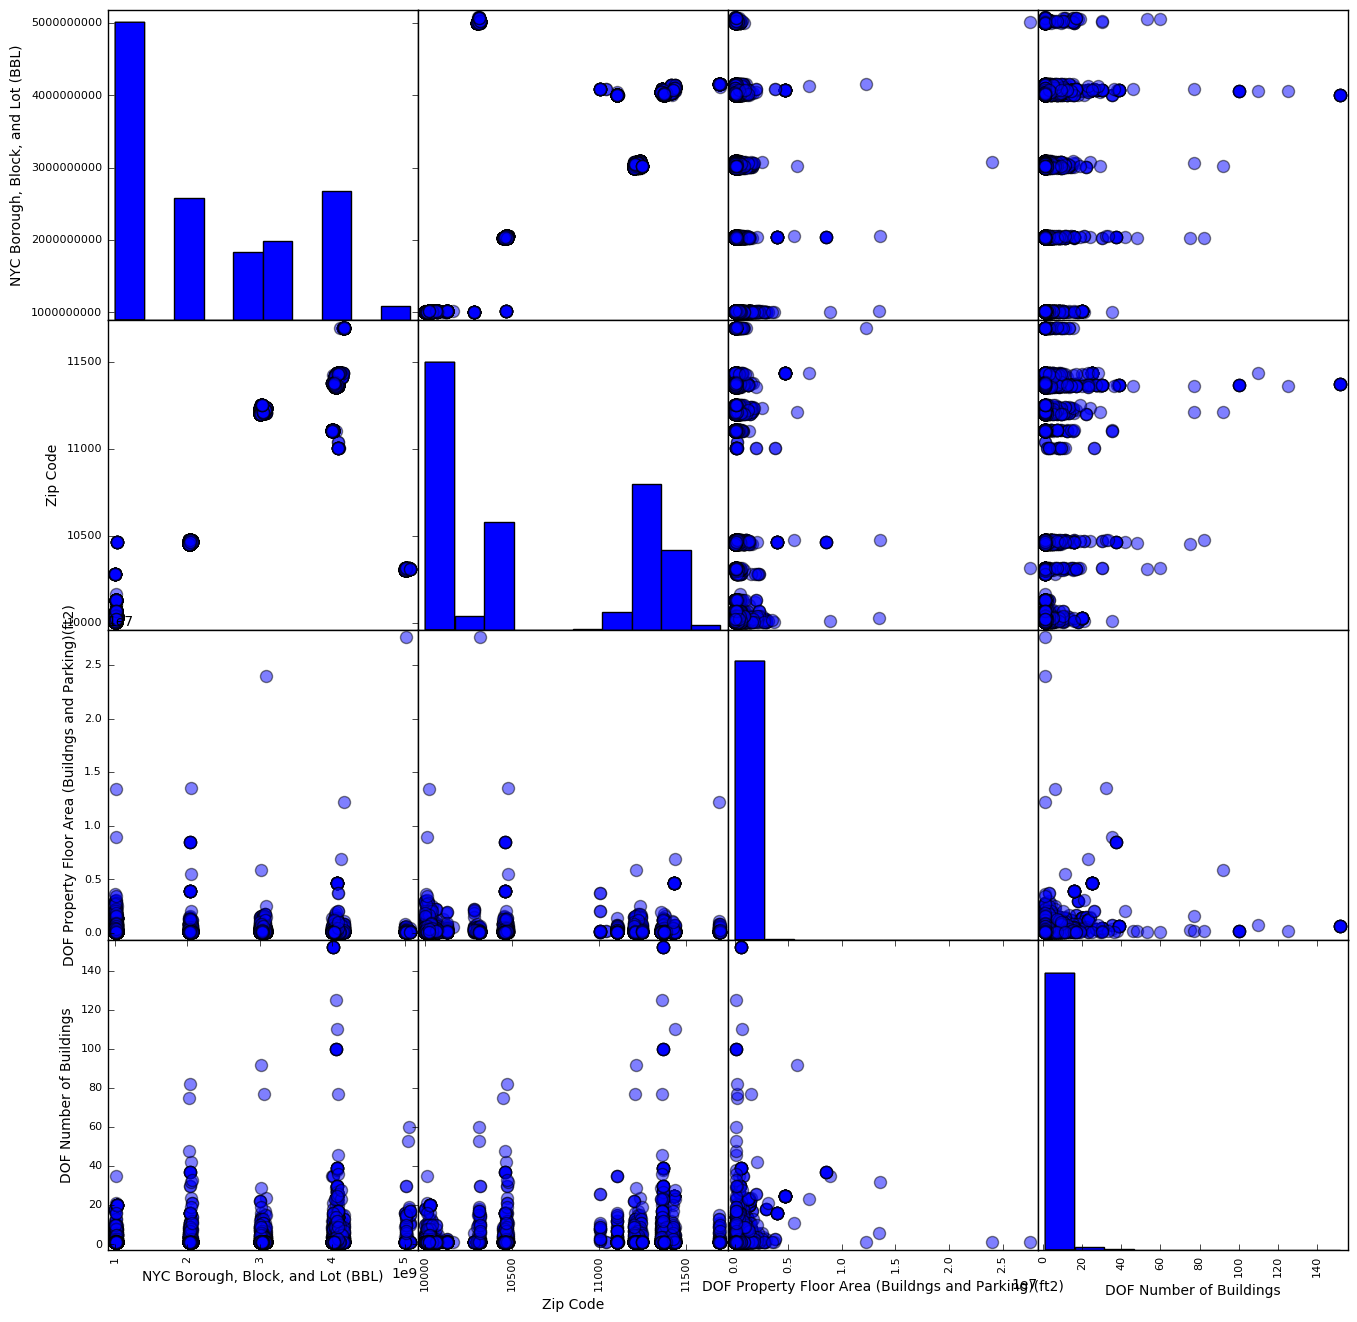

In [13]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16))

In [14]:
nrg2 = nrg.rename(columns = {'NYC Borough, Block, and Lot (BBL)': 'BBL'}) #renaming BBL Column
nrg2.head()

,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,Site EUI(kBtu/ft2),...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
Record Number,,,,,,,,,,,,,,,,,,,,,
12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,NaN,...,Yes,None,NaN,NaN,NaN,NaN,NaN,82730.0,NaN,1.0
12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN
12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,NaN,...,No,None,NaN,NaN,NaN,NaN,NaN,440360.0,NaN,1.0
15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,NaN,...,NaN,None,Not Available,NaN,NaN,NaN,50000,NaN,Multifamily Housing,NaN


In [15]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
    
    
indx = (np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg['Site EUI(kBtu/ft2)'][~indx] = float('NaN')

indx2 = (np.vectorize(canconvert)(nrg['Reported Property Floor Area (Building(s)) (ft²)']))
print ("invalid entries changed to NaN %d"%sum(indx2))
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx2] = float('NaN')
    

invalid entries changed to NaN 15513
invalid entries changed to NaN 15430


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
nrg.drop(['Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Zip Code',
       'DOF Benchmarking Submission Status', 'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings'], axis = 1, inplace = True)

In [17]:
nrg.head()

,"NYC Borough, Block, and Lot (BBL)",Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
Record Number,,,
12086,1.000410e+09,NaN,918919
14354,4.021460e+09,NaN,NaN
12150,2.027620e+09,NaN,64200
12590,1.006700e+09,NaN,NaN
15591,2.048300e+09,NaN,50000


In [18]:
# Calculating total building energy consumption
nrg['total_energy'] = nrg['Site EUI(kBtu/ft2)'].astype(float) * nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)
nrg.astype(float).head()

,"NYC Borough, Block, and Lot (BBL)",Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),total_energy
Record Number,,,,
12086,1.000410e+09,NaN,918919.0,NaN
14354,4.021460e+09,NaN,NaN,NaN
12150,2.027620e+09,NaN,64200.0,NaN
12590,1.006700e+09,NaN,NaN,NaN
15591,2.048300e+09,NaN,50000.0,NaN


In [19]:
bsize.drop(['APPBBL', 'APPDate', 'Address', 'AllZoning1', 'AllZoning2',
       'AreaSource', 'AssessLand', 'AssessTot', 'BldgArea', 'BldgClass',
       'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
       'BuiltCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR',
       'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
       'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
       'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
       'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
       'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_Area',
       'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDist',
       'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
       'Tract2010', 'Version', 'XCoord', 'YCoord',
       'YearAlter1', 'YearAlter2', 'YearBuilt', 'ZMCode', 'ZipCode',
       'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'ZoneMap',
       'geometry'], axis = 1, inplace = True)

In [20]:
bsize.head()

,BBL,UnitsRes,UnitsTotal
0,1.015450e+09,16,18
1,1.007238e+09,50,50
2,1.016800e+09,10,10
3,1.013850e+09,29,32
4,1.011970e+09,26,26


#### Merging Data Sets using BBL 

In [21]:
# Code Source: http://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
nrg2 = nrg.rename(columns = {'NYC Borough, Block, and Lot (BBL)': 'BBL'}) #renaming BBL Column
nrg2.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),total_energy
Record Number,,,,
12086,1.000410e+09,NaN,918919,NaN
14354,4.021460e+09,NaN,NaN,NaN
12150,2.027620e+09,NaN,64200,NaN
12590,1.006700e+09,NaN,NaN,NaN
15591,2.048300e+09,NaN,50000,NaN


In [22]:
# Code Source: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html
bblnrgdata = pd.merge(nrg2, bsize)
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),total_energy,UnitsRes,UnitsTotal
0,1.006700e+09,NaN,NaN,NaN,0,1
1,1.004370e+09,NaN,NaN,NaN,0,4
2,1.013110e+09,125.4,330000,41382000.0,0,56
3,1.009220e+09,NaN,NaN,NaN,148,148
4,1.007400e+09,NaN,68329,NaN,0,1


#### Make a scatter plot first of Energy vs Units

In [23]:
# Code Source: http://stackoverflow.com/questions/16729483/converting-strings-to-floats-in-a-dataframe
bblnrgdata.convert_objects(convert_numeric=True).dtypes

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


BBL                                                 float64
Site EUI(kBtu/ft2)                                  float64
Reported Property Floor Area (Building(s)) (ft²)    float64
total_energy                                        float64
UnitsRes                                              int64
UnitsTotal                                            int64
dtype: object

In [24]:
bblnrgdata.dropna(axis='rows', inplace=True)

In [25]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),total_energy,UnitsRes,UnitsTotal
2,1.013110e+09,125.4,330000,41382000.0,0,56
10,1.010140e+09,154.9,841709,130380724.1,0,2
15,1.007660e+09,122.3,59468,7272936.4,0,8
16,1.008150e+09,117,364000,42588000.0,0,24
18,1.005050e+09,82.1,235370,19323877.0,0,24


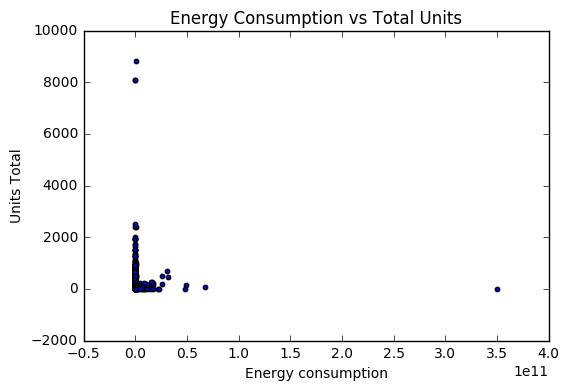

In [26]:
ax = bblnrgdata.plot.scatter(y="UnitsTotal", x="total_energy", s=10)
ax.set_xlabel("Energy consumption")
ax.set_ylabel("Units Total")
ax.set_title('Energy Consumption vs Total Units')
pl.show()

In [27]:
df2 = bblnrgdata[(bblnrgdata['total_energy'] > 0) & (bblnrgdata['UnitsTotal'] > 0)] #cutting my dataset 

In [28]:
df2.describe()

,BBL,total_energy,UnitsRes,UnitsTotal
count,4.997000e+03,4.997000e+03,4997.000000,4997.000000
mean,1.012039e+09,2.146743e+08,101.049230,113.444267
std,5.498015e+06,5.282164e+09,257.467137,261.226491
min,1.000048e+09,5.344000e+03,0.000000,1.000000
25%,1.008280e+09,5.865608e+06,0.000000,27.000000
50%,1.012398e+09,9.300000e+06,56.000000,63.000000
75%,1.015158e+09,1.867657e+07,115.000000,124.000000
max,1.022500e+09,3.501452e+11,8759.000000,8805.000000


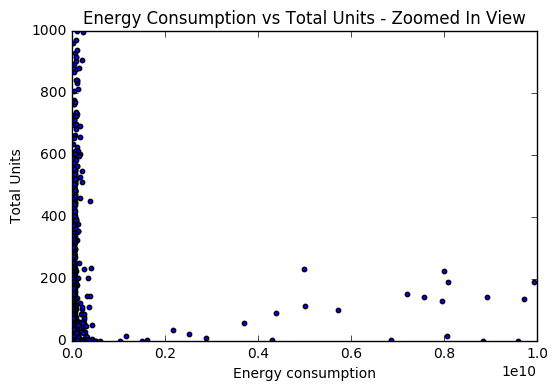

In [29]:
ax = df2.plot.scatter(y="UnitsTotal", x="total_energy", s=10)
ax.set_ylim(1,1000) #limiting range of data to see better in the plot
ax.set_xlim(1000,1e10)
ax.set_xlabel("Energy consumption")
ax.set_ylabel("Total Units")
ax.set_title('Energy Consumption vs Total Units - Zoomed In View')
pl.show()

In [30]:
# Converting values to log

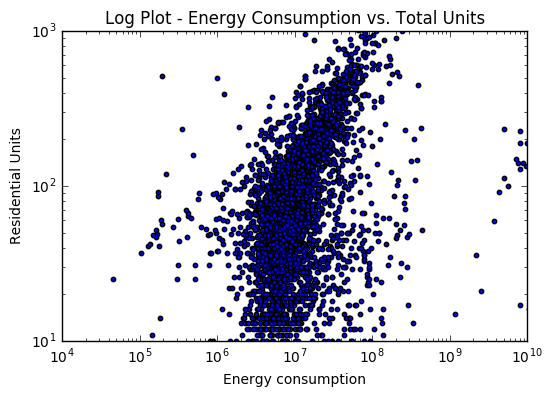

In [31]:
ax = df2.plot.scatter(y="UnitsTotal", x="total_energy", s=10, loglog=True)
ax.set_ylim(10,1000)
ax.set_xlim(1e4,1e10)
ax.set_xlabel("Energy consumption")
ax.set_ylabel("Residential Units")
ax.set_title("Log Plot - Energy Consumption vs. Total Units")
pl.show()

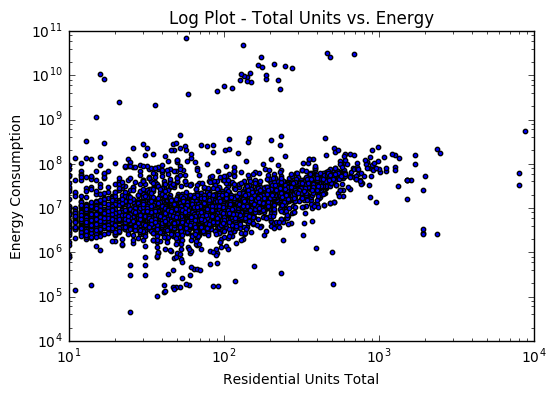

In [32]:
ax = df2.plot.scatter(y="total_energy", x="UnitsTotal", s=10, loglog=True)
plt.ylim(10000,100000000000)
plt.xlim(10,10000)
ax.set_xlabel("Residential Units Total")
ax.set_ylabel("Energy Consumption")
ax.set_title("Log Plot - Total Units vs. Energy")
pl.show()

#### Predict total energy consumption given building units

In [48]:
df2['log_units'] = df2.UnitsTotal.map(np.log10)
df2['log_energy'] = df2.total_energy.map(np.log10)
df2.describe()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,BBL,total_energy,UnitsRes,UnitsTotal,log_units,log_energy
count,4.997000e+03,4.997000e+03,4997.000000,4997.000000,4997.000000,4997.000000
mean,1.012039e+09,2.146743e+08,101.049230,113.444267,1.669122,7.055893
std,5.498015e+06,5.282164e+09,257.467137,261.226491,0.685841,0.528083
min,1.000048e+09,5.344000e+03,0.000000,1.000000,0.000000,3.727866
25%,1.008280e+09,5.865608e+06,0.000000,27.000000,1.431364,6.768313
50%,1.012398e+09,9.300000e+06,56.000000,63.000000,1.799341,6.968483
75%,1.015158e+09,1.867657e+07,115.000000,124.000000,2.093422,7.271297
max,1.022500e+09,3.501452e+11,8759.000000,8805.000000,3.944729,11.544248


In [50]:
df2['log_units_sq'] = df2.log_units*df2.log_units
df2.describe()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,BBL,total_energy,UnitsRes,UnitsTotal,log_units,log_energy,log_units_sq
count,4.997000e+03,4.997000e+03,4997.000000,4997.000000,4997.000000,4997.000000,4997.000000
mean,1.012039e+09,2.146743e+08,101.049230,113.444267,1.669122,7.055893,3.256252
std,5.498015e+06,5.282164e+09,257.467137,261.226491,0.685841,0.528083,1.957379
min,1.000048e+09,5.344000e+03,0.000000,1.000000,0.000000,3.727866,0.000000
25%,1.008280e+09,5.865608e+06,0.000000,27.000000,1.431364,6.768313,2.048802
50%,1.012398e+09,9.300000e+06,56.000000,63.000000,1.799341,6.968483,3.237626
75%,1.015158e+09,1.867657e+07,115.000000,124.000000,2.093422,7.271297,4.382414
max,1.022500e+09,3.501452e+11,8759.000000,8805.000000,3.944729,11.544248,15.560890


In [51]:
y = df2.log_energy
X = sm.add_constant(df2.log_units)

In [52]:
model = sm.OLS(y, X, missing='drop')
result = model.fit()

In [36]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_energy   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     63.79
Date:                Wed, 19 Oct 2016   Prob (F-statistic):           1.70e-15
Time:                        13:32:56   Log-Likelihood:                -3867.6
No. Observations:                4997   AIC:                             7739.
Df Residuals:                    4995   BIC:                             7752.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.9116      0.020    353.804      0.000         6.873     6.950
log_units      0.0865      0.011      7.987      0.000         0.065     0.108
==============================================================================
Omnibus:                     2221.478   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27205.366
Skew:                           1.791   Prob(JB):                         0.00
Kurtosis:                      13.855   Cond. No.                         6.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

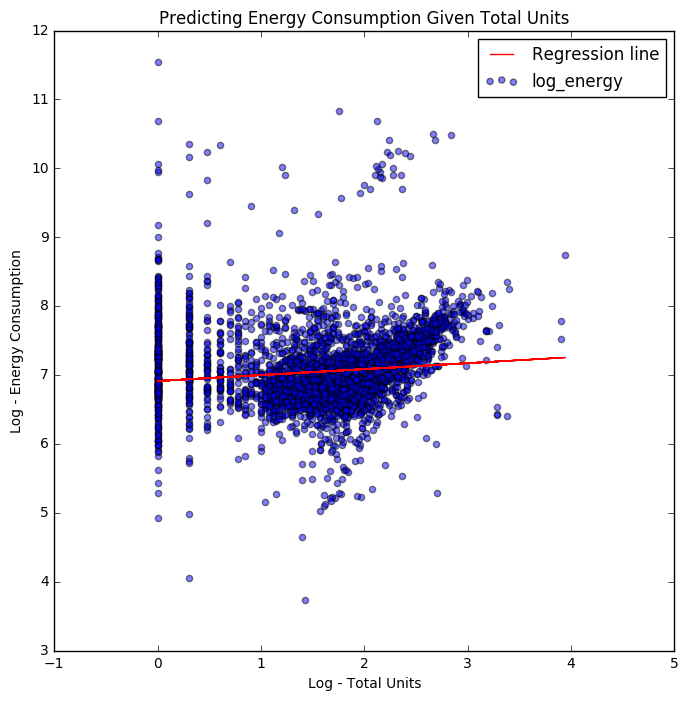

In [37]:
y_fit = result.predict(X)
plt.figure(figsize=(8,8))
xlabel('Log - Total Units')
ylabel('Log - Energy Consumption')
plt.title("Predicting Energy Consumption Given Total Units")
plt.scatter(df2.log_units, y, alpha=.5, s=20 )
plt.plot(df2.log_units, y_fit, color = 'r', label = 'Regression line')
plt.legend()
plt.show()

#### Predicting Total Units given Energy Consumption

In [38]:
y2 = df2.log_units
X2 = sm.add_constant(df2.log_energy)

In [39]:
model1 = sm.OLS(y2, X2, missing='drop')
result1 = model1.fit()

In [40]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_units   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     63.79
Date:                Wed, 19 Oct 2016   Prob (F-statistic):           1.70e-15
Time:                        13:32:57   Log-Likelihood:                -5173.8
No. Observations:                4997   AIC:                         1.035e+04
Df Residuals:                    4995   BIC:                         1.036e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6401      0.129      4.954      0.000         0.387     0.893
log_energy     0.1458      0.018      7.987      0.000         0.110     0.182
==============================================================================
Omnibus:                      754.081   Durbin-Watson:                   1.517
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1145.004
Skew:                          -1.090   Prob(JB):                    2.32e-249
Kurtosis:                       3.863   Cond. No.                         96.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

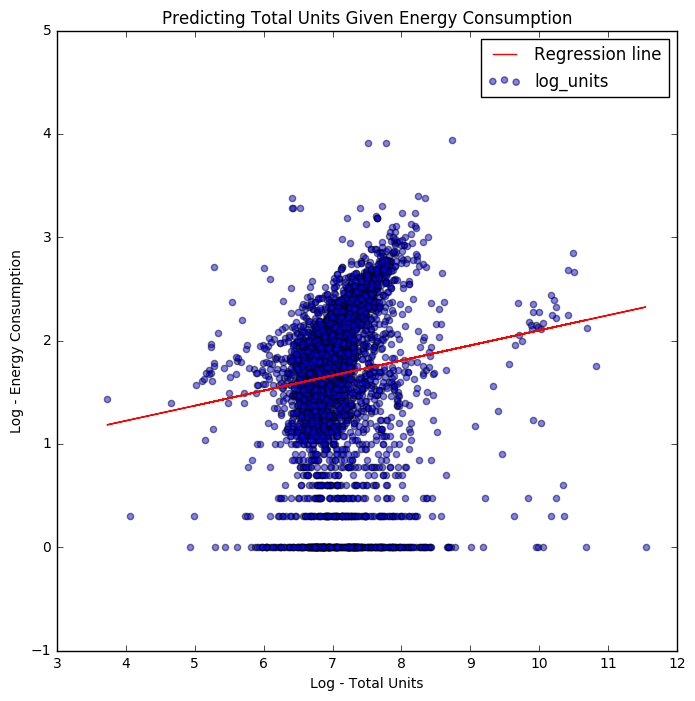

In [41]:
y_fit2 = result1.predict(X2)
plt.figure(figsize=(8,8))
xlabel('Log - Total Units')
ylabel('Log - Energy Consumption')
plt.title('Predicting Total Units Given Energy Consumption')
plt.scatter(df2.log_energy, y2, alpha=.5, s=20 )
plt.plot(df2.log_energy, y_fit2, color = 'r', label = 'Regression line')
plt.legend()
plt.show()

#### Chi-Square Test

In [42]:
# Calculate chi square statistic for first model
chisq1 = np.sum(((y_fit - y)**2)/np.sqrt(y)**2)
chisq1

181.37768375605171

In [44]:
# Calculate chi square statistic for second model
chisq2 = np.sum(((y_fit2 - y2)**2)/np.sqrt(y2)**2)
chisq2

inf

#### The chi-square test of the first model calculates a lower number which means that it decribes the data better (the ideal chi-sq model has a value of 1). Therefore, it makes sense to predict energy consumption given total units and I will use that model.  

#### Second degree Polynomial Fit

In [53]:
df2.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),total_energy,UnitsRes,UnitsTotal,log_units,log_energy,log_units_sq
2,1.013110e+09,125.4,330000,41382000.0,0,56,1.748188,7.616811,3.056161
10,1.010140e+09,154.9,841709,130380724.1,0,2,0.301030,8.115213,0.090619
15,1.007660e+09,122.3,59468,7272936.4,0,8,0.903090,6.861710,0.815572
16,1.008150e+09,117,364000,42588000.0,0,24,1.380211,7.629287,1.904983
18,1.005050e+09,82.1,235370,19323877.0,0,24,1.380211,7.286094,1.904983


In [54]:
y = df2.log_energy
X3 = df2[['log_units', 'log_units_sq']]
X3 = sm.add_constant(X3)

In [55]:
model3 = sm.OLS(y, X3, missing='drop')
result3 = model3.fit()

In [56]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_energy   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     441.2
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          3.70e-177
Time:                        13:50:13   Log-Likelihood:                -3492.9
No. Observations:                4997   AIC:                             6992.
Df Residuals:                    4994   BIC:                             7011.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            7.3025      0.023    320.972      0.000         7.258     7.347
log_units       -0.7555      0.031    -24.158      0.000        -0.817    -0.694
log_units_sq     0.3115      0.011     28.429      0.000         0.290     0.333
==============================================================================
Omnibus:                     2332.177   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40093.312
Skew:                           1.796   Prob(JB):                         0.00
Kurtosis:                      16.404   Cond. No.                         23.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

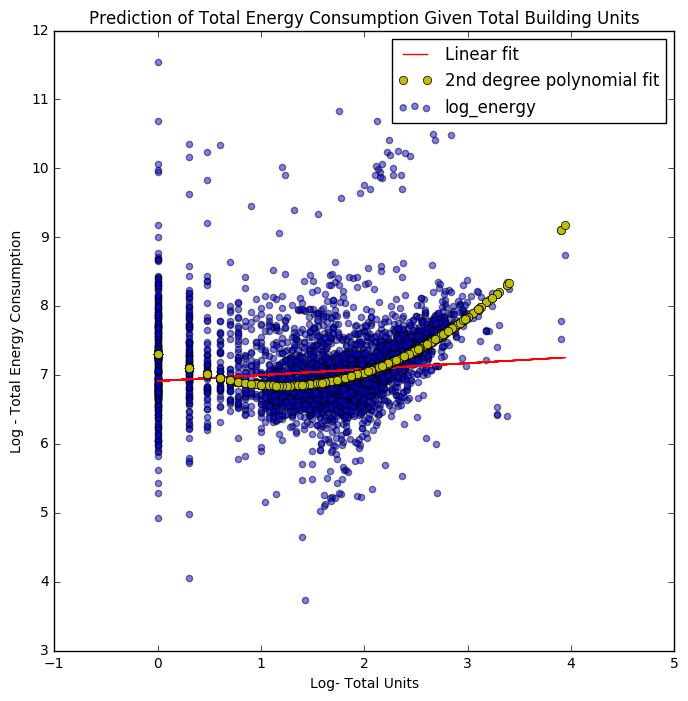

In [58]:
y_fit3 = result3.predict(X3)
plt.figure(figsize=(8,8))
xlabel('Log- Total Units')
ylabel('Log - Total Energy Consumption')
plt.title('Prediction of Total Energy Consumption Given Total Building Units')
plt.scatter(df2.log_units, y, alpha=.5, s=20 )
plt.plot(df2.log_units, y_fit, color = 'r', label = 'Linear fit')
plt.plot(df2.log_units, y_fit3,'o', color = 'y', label = '2nd degree polynomial fit')
plt.legend()
plt.show()

#### Likelihood ratio test

In [65]:
print ("LR : ", -2 * (-result.llf - (-result3.llf)))

LR :  -749.570813263


In [66]:
#checking work
result3.compare_lr_test(result)

(749.57081326309617, 4.9741887237358717e-165, 1.0)

#### LR ratio of 749 is a lot larger than 3.84 (chi-square critical value for a=0.05 and df=1).Therefore, we can assume that that the polynomial model fits the data better than the linear model.